In [1]:
import sys
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Sequence, Tuple, Union

import math
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

from shapely.geometry import LineString, Point, MultiLineString
from tueplots import axes, bundles
from tueplots.constants.color import rgb

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

from src.preprocess_data import preprocess_accident_data

In [2]:
# load accidents data
accidents_df = preprocess_accident_data()


Loaded 9 files -> combined shape: (2098019, 32)
Dropped irrelevant columns -> shape: (2098019, 24)
Filtered to bicycle accidents -> shape: (626844, 24)
Filtered to bicycle accidents in Berlin -> shape: (33181, 24)


In [3]:
segments_df = gpd.read_parquet(
    "../data/merged/berlin_bike_accident_strava_risk_core_panel.parquet"
).to_crs(epsg=4326)

junction_df = gpd.read_parquet(
    "../data/merged/berlin_bike_accident_node_panel.parquet"
).to_crs(epsg=4326)

# one geometry per node_id
crossings_gdf = (
    junction_df[["node_id", "geometry"]]
    .dropna(subset=["node_id", "geometry"])
    .drop_duplicates(subset=["node_id"])
    .copy()
)
crossings_gdf = gpd.GeoDataFrame(crossings_gdf, geometry="geometry", crs=junction_df.crs)

print("segments_df:", segments_df.shape)
print("junction_df:", junction_df.shape)
print("crossings_gdf:", crossings_gdf.shape)
print("accidents_df:", accidents_df.shape)


segments_df: (297480, 66)
junction_df: (177334, 64)
crossings_gdf: (2924, 2)
accidents_df: (33181, 24)


In [4]:
# This code builds a routing graph for a given (year, month), attaches risk,
# and provides shortest / constrained-min-risk routing utilities.

from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString, Point


# Helpers

NodeKey = Tuple[float, float]


def _edge_endpoints_as_node_keys(linestring: LineString, ndigits: int = 0) -> Tuple[NodeKey, NodeKey]:
    """
    Create stable node keys from LineString endpoints in a metric CRS.

    For UTM meters:
      ndigits=0 => 1m rounding (robust)
      ndigits=1 => 0.1m rounding (less robust)
      ndigits=3 => 1mm rounding (usually too strict)
    """
    (x1, y1) = linestring.coords[0]
    (x2, y2) = linestring.coords[-1]
    a = (round(float(x1), ndigits), round(float(y1), ndigits))
    b = (round(float(x2), ndigits), round(float(y2), ndigits))
    return a, b


def _risk_fallback_value(series: pd.Series, *, strategy: str = "median", default: float = 0.0) -> float:
    """
    Decide a safe fallback risk if a segment/node risk is NaN.

    strategy:
      - "median": median of observed values for that month panel
      - "mean": mean of observed values
      - "zero": always 0
      - "high": conservative high value (90th percentile if possible)
    """
    s = pd.to_numeric(series, errors="coerce")
    s = s[np.isfinite(s)]
    if len(s) == 0:
        return float(default)

    if strategy == "median":
        return float(np.nanmedian(s))
    if strategy == "mean":
        return float(np.nanmean(s))
    if strategy == "high":
        return float(np.nanpercentile(s, 90))
    if strategy == "zero":
        return 0.0

    return float(np.nanmedian(s))


def _build_node_risk_lookup(
    junction_panel_gdf: gpd.GeoDataFrame,
    year: int,
    month: int,
    *,
    node_id_col: str = "node_id",
    node_risk_col: str = "risk_accidents_per_10k_trips",
    fallback: float = 0.0,
    fallback_strategy: str = "median",
) -> Dict[str, float]:
    """
    Returns dict[node_id(str)] -> node_risk for the given (year, month).

    Notes:
      - If (year, month) missing entirely: returns {} (caller chooses behavior).
      - If a node risk value is NaN: filled by fallback computed from the month panel.
    """
    if junction_panel_gdf is None or len(junction_panel_gdf) == 0:
        return {}

    j = junction_panel_gdf[(junction_panel_gdf["year"] == year) & (junction_panel_gdf["month"] == month)].copy()
    if j.empty:
        return {}

    if node_risk_col not in j.columns:
        raise KeyError(f"Missing node risk column '{node_risk_col}' in junction_panel_gdf")

    # Ensure one row per node_id-month; if multiple exist, take mean (shouldn't happen, but safe).
    j = j.groupby(node_id_col, as_index=False)[node_risk_col].mean()

    fb = _risk_fallback_value(j[node_risk_col], strategy=fallback_strategy, default=fallback)
    j[node_risk_col] = pd.to_numeric(j[node_risk_col], errors="coerce").fillna(fb)

    return dict(zip(j[node_id_col].astype(str), j[node_risk_col].astype(float)))


def _attach_node_ids_to_graph_nodes(
    G: nx.Graph,
    crossings_gdf: gpd.GeoDataFrame,
    *,
    metric_epsg: int = 32633,
    node_id_col: str = "node_id",
    max_snap_m: float = 20.0,
) -> None:
    """
    Map your existing 'node_id' (junctions/crossings) onto graph nodes.

    We snap each crossing point to the nearest graph node (within max_snap_m).
    Stores: G.nodes[node_key]["node_id"] = <id>

    Critical for applying junction risk penalties.
    """
    if crossings_gdf is None or len(crossings_gdf) == 0:
        return

    crossings_m = crossings_gdf.to_crs(epsg=metric_epsg).copy()

    graph_nodes = list(G.nodes())
    if len(graph_nodes) == 0:
        return

    graph_xy = np.array(graph_nodes, dtype=float)

    for _, row in crossings_m.iterrows():
        if row.geometry is None or row.geometry.is_empty:
            continue

        nid = str(row[node_id_col])
        x, y = float(row.geometry.x), float(row.geometry.y)

        d2 = (graph_xy[:, 0] - x) ** 2 + (graph_xy[:, 1] - y) ** 2
        j = int(d2.argmin())
        dist = float(math.sqrt(d2[j]))
        if dist <= max_snap_m:
            node_key = graph_nodes[j]
            G.nodes[node_key]["node_id"] = nid


def _iter_edges(G: nx.Graph):
    """
    Unified iterator over edges returning (u, v, key, data) where key is None for non-multigraphs.
    """
    if isinstance(G, nx.MultiGraph):
        for u, v, k, data in G.edges(keys=True, data=True):
            yield u, v, k, data
    else:
        for u, v, data in G.edges(data=True):
            yield u, v, None, data


def _get_edge_data_for_step(G: nx.Graph, a, b, *, choose_by: str = "length_m") -> dict:
    """
    For MultiGraph: pick the parallel edge (between a,b) that minimizes choose_by
    (fallback to length_m).
    For Graph: return edge data.
    """
    if isinstance(G, nx.MultiGraph):
        edges = G.get_edge_data(a, b)
        if edges is None:
            raise KeyError(f"No edge between {a} and {b}")

        best = None
        best_val = None
        for _, d in edges.items():
            val = d.get(choose_by, d.get("length_m", 0.0))
            if best is None or val < best_val:
                best = d
                best_val = val
        return best
    else:
        d = G.get_edge_data(a, b)
        if d is None:
            raise KeyError(f"No edge between {a} and {b}")
        return d


# -----------------------------
# Graph construction
# -----------------------------

@dataclass(frozen=True)
class GraphBuildConfig:
    metric_epsg: int = 32633
    endpoint_ndigits: int = 0
    seg_id_col: str = "counter_name"
    seg_exposure_col_candidates: Tuple[str, ...] = ("monthly_strava_trips", "sum_strava_total_trip_count")
    seg_risk_col_candidates: Tuple[str, ...] = ("risk_accidents_per_10k_trips", "risk_accidents_per_trip")
    auto_scale_trip_risk_to_per_10k: bool = True
    risk_fallback_strategy: str = "median"   # median/mean/high/zero
    risk_fallback_default: float = 0.0
    drop_edges_with_zero_exposure: bool = True
    keep_parallel_edges: bool = True


def build_routing_graph_for_month(
    segments_panel_gdf: gpd.GeoDataFrame,
    year: int,
    month: int,
    *,
    config: GraphBuildConfig = GraphBuildConfig(),
) -> nx.Graph:
    """
    Build a routing graph for one (year, month) from segment LineStrings.

    Nodes: segment endpoints (rounded in metric CRS).
    Edges carry:
      - segment_id
      - length_m
      - seg_risk (scaled for routing; per-10k trips)
      - geometry
    """
    df = segments_panel_gdf[(segments_panel_gdf["year"] == year) & (segments_panel_gdf["month"] == month)].copy()
    if df.empty:
        raise ValueError(f"No segment rows found for year={year}, month={month}")

    df_m = df.to_crs(epsg=config.metric_epsg).copy()

    # Pick exposure column
    exposure_col = None
    for c in config.seg_exposure_col_candidates:
        if c in df_m.columns:
            exposure_col = c
            break
    if exposure_col is None:
        raise KeyError(f"Missing exposure column. Tried: {config.seg_exposure_col_candidates}")

    # Pick risk column
    risk_col = None
    for c in config.seg_risk_col_candidates:
        if c in df_m.columns:
            risk_col = c
            break
    if risk_col is None:
        raise KeyError(f"Missing risk column. Tried: {config.seg_risk_col_candidates}")

    # Ensure uniqueness at segment-month level
    if df_m[[config.seg_id_col, "year", "month"]].duplicated().any():
        dups = int(df_m[[config.seg_id_col, "year", "month"]].duplicated().sum())
        raise ValueError(f"segments_panel_gdf has {dups} duplicate rows for (segment,year,month). Fix upstream aggregation.")

    df_m[exposure_col] = pd.to_numeric(df_m[exposure_col], errors="coerce")
    if config.drop_edges_with_zero_exposure:
        df_m = df_m[df_m[exposure_col].fillna(0) > 0].copy()

    # Compute fallback risk (month-specific)
    fb = _risk_fallback_value(df_m[risk_col], strategy=config.risk_fallback_strategy, default=config.risk_fallback_default)

    # Build graph
    G = nx.MultiGraph() if config.keep_parallel_edges else nx.Graph()

    for _, row in df_m.iterrows():
        geom = row.geometry
        if geom is None or geom.is_empty:
            continue
        if not isinstance(geom, LineString):
            # If MultiLineString, take the longest component
            try:
                parts = list(geom.geoms)
                parts = [p for p in parts if isinstance(p, LineString) and not p.is_empty]
                if not parts:
                    continue
                geom = max(parts, key=lambda g: g.length)
            except Exception:
                continue

        u, v = _edge_endpoints_as_node_keys(geom, ndigits=config.endpoint_ndigits)
        seg_id = str(row[config.seg_id_col])
        length_m = float(geom.length)

        seg_risk = pd.to_numeric(row[risk_col], errors="coerce")
        if pd.isna(seg_risk):
            seg_risk = fb
        seg_risk = float(seg_risk)

        # If only per-trip risk exists, scale to per-10k for routing stability
        if (risk_col == "risk_accidents_per_trip") and config.auto_scale_trip_risk_to_per_10k:
            seg_risk *= 10_000.0

        if u not in G:
            G.add_node(u, x=u[0], y=u[1])
        if v not in G:
            G.add_node(v, x=v[0], y=v[1])

        G.add_edge(
            u,
            v,
            segment_id=seg_id,
            length_m=length_m,
            seg_risk=seg_risk,
            geometry=geom,
        )

    if G.number_of_edges() == 0:
        raise ValueError(f"Graph has 0 edges for year={year}, month={month} after filtering. Check exposure coverage and filters.")

    return G


# Cost and risk attributes
@dataclass(frozen=True)
class RiskConfig:
    eta: float = 1.0  # weight of junction penalty inside the R(P) objective


def add_node_penalty_attributes(
    G: nx.Graph,
    *,
    node_risk_by_node_id: Optional[Dict[str, float]] = None,
) -> None:
    if node_risk_by_node_id is None:
        node_risk_by_node_id = {}

    for u, v, k, data in _iter_edges(G):
        uid = G.nodes[u].get("node_id")
        vid = G.nodes[v].get("node_id")
        ru = float(node_risk_by_node_id.get(uid, 0.0)) if uid is not None else 0.0
        rv = float(node_risk_by_node_id.get(vid, 0.0)) if vid is not None else 0.0
        node_penalty = 0.5 * (ru + rv)

        if isinstance(G, nx.MultiGraph):
            G.edges[u, v, k]["node_penalty"] = float(node_penalty)
        else:
            data["node_penalty"] = float(node_penalty)


def add_risk_total_attributes(
    G: nx.Graph,
    *,
    risk_cfg: RiskConfig = RiskConfig(eta=1.0),
) -> None:
    """
    Adds 'risk_total' to each edge:
      risk_total = seg_risk + eta * node_penalty

    Requires: seg_risk exists; node_penalty exists (0 if no node ids/risks attached).
    """
    for u, v, k, data in _iter_edges(G):
        seg_risk = float(data.get("seg_risk", 0.0))
        node_penalty = float(data.get("node_penalty", 0.0))
        risk_total = seg_risk + risk_cfg.eta * node_penalty

        if isinstance(G, nx.MultiGraph):
            G.edges[u, v, k]["risk_total"] = float(risk_total)
        else:
            data["risk_total"] = float(risk_total)


# Routing utilities

def nearest_graph_node(
    G: nx.Graph,
    lon: float,
    lat: float,
    *,
    metric_epsg: int = 32633,
) -> NodeKey:
    """
    Snap an (lon, lat) point to the closest graph node.
    Brute force over nodes (OK for moderate graphs). Replace with KDTree if needed.
    """
    p = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:4326").to_crs(epsg=metric_epsg).iloc[0]
    x, y = float(p.x), float(p.y)

    nodes = list(G.nodes())
    if len(nodes) == 0:
        raise ValueError("Graph has no nodes")

    xy = np.array(nodes, dtype=float)
    d2 = (xy[:, 0] - x) ** 2 + (xy[:, 1] - y) ** 2
    idx = int(d2.argmin())
    return nodes[idx]


def route_stats(G: nx.Graph, path: List[NodeKey], *, choose_by: str = "length_m") -> Dict[str, float]:
    """
    Summarize route length and risk along a node-path.

    For MultiGraph, the parallel edge between consecutive nodes is chosen by
    minimizing choose_by. This MUST match the weight used when the path was computed,
    otherwise stats can be inconsistent.
    """
    total_len = 0.0
    total_seg_risk = 0.0
    total_node_penalty = 0.0
    total_risk_total = 0.0

    for a, b in zip(path[:-1], path[1:]):
        d = _get_edge_data_for_step(G, a, b, choose_by=choose_by)

        total_len += float(d.get("length_m", 0.0))
        total_seg_risk += float(d.get("seg_risk", 0.0))
        total_node_penalty += float(d.get("node_penalty", 0.0))
        total_risk_total += float(d.get("risk_total", d.get("seg_risk", 0.0)))

    return {
        "length_m": total_len,
        "seg_risk_sum": total_seg_risk,
        "node_penalty_sum": total_node_penalty,
        "risk_total_sum": total_risk_total,
    }


def shortest_path_by(G: nx.Graph, source: NodeKey, target: NodeKey, weight: str) -> Optional[List[NodeKey]]:
    try:
        return nx.shortest_path(G, source=source, target=target, weight=weight, method="dijkstra")
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return None


def constrained_min_risk_route(
    G: nx.Graph,
    source: NodeKey,
    target: NodeKey,
    *,
    eps: float = 0.10,                 # allow up to +10% distance over shortest
    length_attr: str = "length_m",
    risk_attr: str = "risk_total",
    lambdas: Optional[List[float]] = None,
) -> Optional[List[NodeKey]]:
    """
    Minimize risk subject to length <= (1+eps) * shortest_length.

    Implementation: parametric sweep with a weighted sum:
      minimize (risk + lambda * length)
    and select the best path that satisfies the length constraint.
    """
    shortest_len_path = shortest_path_by(G, source, target, weight=length_attr)
    if shortest_len_path is None:
        return None  # disconnected

    shortest_len = route_stats(G, shortest_len_path, choose_by=length_attr)["length_m"]
    max_len = (1.0 + eps) * shortest_len

    if lambdas is None:
        lambdas = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0]

    best_path: Optional[List[NodeKey]] = None
    best_risk: Optional[float] = None
    best_len: Optional[float] = None

    for lam in lambdas:
        # Build temporary combined weight on edges: risk + lambda*length
        for u, v, k, d in _iter_edges(G):
            comb = float(d.get(risk_attr, 0.0)) + lam * float(d.get(length_attr, 0.0))
            if isinstance(G, nx.MultiGraph):
                G.edges[u, v, k]["_comb"] = comb
            else:
                d["_comb"] = comb

        p = shortest_path_by(G, source, target, weight="_comb")
        if p is None:
            continue

        st = route_stats(G, p, choose_by="_comb")  # consistent parallel-edge choice

        if st["length_m"] <= max_len:
            candidate_risk = st["risk_total_sum"]  
            if (
                best_path is None
                or candidate_risk < best_risk
                or (candidate_risk == best_risk and st["length_m"] < best_len)
            ):
                best_path = p
                best_risk = candidate_risk
                best_len = st["length_m"]

    return best_path if best_path is not None else shortest_len_path


# End-to-end wrapper

@dataclass(frozen=True)
class RoutingMonthArtifacts:
    G: nx.Graph
    year: int
    month: int
    segment_risk_col_used: str
    node_risk_col_used: Optional[str]
    notes: str


def build_graph_with_risk_for_month(
    segments_panel_gdf: gpd.GeoDataFrame,
    year: int,
    month: int,
    *,
    crossings_gdf: Optional[gpd.GeoDataFrame] = None,
    junction_panel_gdf: Optional[gpd.GeoDataFrame] = None,
    graph_cfg: GraphBuildConfig = GraphBuildConfig(),
    node_risk_col: str = "risk_accidents_per_10k_trips",
    node_snap_m: float = 30.0,
    node_risk_fallback_strategy: str = "median",
    node_risk_fallback_default: float = 0.0,
    risk_cfg: RiskConfig = RiskConfig(eta=1.0),
) -> RoutingMonthArtifacts:
    """
    Build the month-specific routing graph and attach cost/risk attributes.

      1) Build graph edges from segment panel for (year, month)
      2) Optionally attach node_ids to graph nodes by snapping crossings_gdf points
      3) Optionally build node risk lookup from junction_panel_gdf for (year, month)
      4) Add edge costs and risk_total (segment + eta * junction penalty)
    """
    G = build_routing_graph_for_month(segments_panel_gdf, year, month, config=graph_cfg)

    node_risk_lookup: Dict[str, float] = {}
    used_node_risk_col: Optional[str] = None
    notes: List[str] = []

    # junction info is needed
    need_junction = (risk_cfg.eta != 0.0)

    if need_junction:
        if crossings_gdf is None or junction_panel_gdf is None:
            notes.append("junction risk requested (eta!=0) but crossings_gdf/junction_panel_gdf not provided -> junction penalty set to 0.")
        else:
            _attach_node_ids_to_graph_nodes(
                G,
                crossings_gdf,
                metric_epsg=graph_cfg.metric_epsg,
                node_id_col="node_id",
                max_snap_m=node_snap_m,
            )
            node_risk_lookup = _build_node_risk_lookup(
                junction_panel_gdf,
                year,
                month,
                node_id_col="node_id",
                node_risk_col=node_risk_col,
                fallback=node_risk_fallback_default,
                fallback_strategy=node_risk_fallback_strategy,
            )
            used_node_risk_col = node_risk_col

            attached = sum(1 for n in G.nodes if "node_id" in G.nodes[n])
            notes.append(f"Attached node_id to {attached}/{G.number_of_nodes()} graph nodes (snap<= {node_snap_m}m).")

    add_node_penalty_attributes(G, node_risk_by_node_id=node_risk_lookup)
    add_risk_total_attributes(G, risk_cfg=risk_cfg)

    # Determine which segment risk column was used (for transparency)
    seg_risk_col_used = None
    for c in graph_cfg.seg_risk_col_candidates:
        if c in segments_panel_gdf.columns:
            seg_risk_col_used = c
            break
    if seg_risk_col_used is None:
        seg_risk_col_used = "(unknown)"

    # If per-trip risk was used but scaled, note it
    if seg_risk_col_used == "risk_accidents_per_trip" and graph_cfg.auto_scale_trip_risk_to_per_10k:
        notes.append("Scaled segment risk_accidents_per_trip by 10,000 for routing stability (per-10k trips).")

    if risk_cfg.eta != 0.0:
        notes.append(f"Risk objective uses eta={risk_cfg.eta} for junction penalty weighting.")

    return RoutingMonthArtifacts(
        G=G,
        year=year,
        month=month,
        segment_risk_col_used=seg_risk_col_used,
        node_risk_col_used=used_node_risk_col,
        notes=" ".join(notes).strip(),
    )


# Verification utilities

def verify_graph_sanity(
    artifacts: RoutingMonthArtifacts,
    *,
    expect_junction_penalties: bool = False,
) -> Dict[str, Union[int, float, str]]:
    """
    Quick, paper-friendly sanity checks:
      - graph non-empty
      - risk magnitude reasonable
      - node_penalty and risk_total ranges
      - node ids attached when expected
    """
    G = artifacts.G

    seg_risks = [float(d.get("seg_risk", 0.0)) for _, _, _, d in _iter_edges(G)]
    risk_totals = [float(d.get("risk_total", 0.0)) for _, _, _, d in _iter_edges(G)]
    lengths = [float(d.get("length_m", 0.0)) for _, _, _, d in _iter_edges(G)]
    node_pen = [float(d.get("node_penalty", 0.0)) for _, _, _, d in _iter_edges(G)]

    attached_nodes = sum(1 for n in G.nodes if "node_id" in G.nodes[n])

    out: Dict[str, Union[int, float, str]] = {
        "n_nodes": G.number_of_nodes(),
        "n_edges": G.number_of_edges(),
        "seg_risk_min": float(np.min(seg_risks)) if seg_risks else float("nan"),
        "seg_risk_median": float(np.median(seg_risks)) if seg_risks else float("nan"),
        "seg_risk_max": float(np.max(seg_risks)) if seg_risks else float("nan"),
        "risk_total_median": float(np.median(risk_totals)) if risk_totals else float("nan"),
        "risk_total_max": float(np.max(risk_totals)) if risk_totals else float("nan"),
        "length_median": float(np.median(lengths)) if lengths else float("nan"),
        "node_penalty_nonzero_share": float(np.mean(np.array(node_pen) > 0)) if node_pen else 0.0,
        "graph_node_ids_attached": attached_nodes,
        "notes": artifacts.notes,
    }

    if expect_junction_penalties and attached_nodes == 0:
        out["warning"] = "Expected junction penalties, but no graph nodes have node_id attached. Check snapping tolerance and CRS."
    return out


In [5]:
# Run routing for ONE OD pair

def run_one_od_routing(
    *,
    segments_panel_gdf: gpd.GeoDataFrame,
    crossings_gdf: gpd.GeoDataFrame,
    junction_panel_gdf: gpd.GeoDataFrame,
    year: int,
    month: int,
    origin_lonlat: tuple[float, float],
    dest_lonlat: tuple[float, float],
    eps: float = 0.10,
    eta: float = 1.0,
    metric_epsg: int = 32633,
):
    """
    Builds the month graph, snaps OD to graph nodes, and returns:
      - shortest-by-length route (P_dist)
      - constrained min-risk route within (1+eps) distance (P_safe), minimizing risk_total
      - optional shortest-by-cost route (mixed objective) for comparison

    origin_lonlat/dest_lonlat are (lon, lat) in EPSG:4326.
    """
    artifacts = build_graph_with_risk_for_month(
        segments_panel_gdf,
        year,
        month,
        crossings_gdf=crossings_gdf,
        junction_panel_gdf=junction_panel_gdf,
        graph_cfg=GraphBuildConfig(metric_epsg=metric_epsg),
        risk_cfg=RiskConfig(eta=eta),
        node_snap_m=20.0,
    )

    sanity = verify_graph_sanity(
        artifacts,
        expect_junction_penalties=(eta != 0.0),
    )

    G = artifacts.G
    o_lon, o_lat = origin_lonlat
    d_lon, d_lat = dest_lonlat

    src = nearest_graph_node(G, o_lon, o_lat, metric_epsg=metric_epsg)
    dst = nearest_graph_node(G, d_lon, d_lat, metric_epsg=metric_epsg)

    # Baseline: shortest distance (P_dist)
    p_len = shortest_path_by(G, src, dst, weight="length_m")
    if p_len is None:
        return {
            "status": "disconnected",
            "graph_sanity": sanity,
            "origin_node": src,
            "dest_node": dst,
            "notes": artifacts.notes,
        }
    st_len = route_stats(G, p_len, choose_by="length_m")

    # Constrained min-risk (P_safe) minimizing risk_total, with detour constraint
    p_safe = constrained_min_risk_route(
        G,
        src,
        dst,
        eps=eps,
        length_attr="length_m",
        risk_attr="risk_total",
    )
    # If graph is connected, p_safe will at least fall back to p_len (see routing util)
    st_safe = route_stats(G, p_safe, choose_by="risk_total") if p_safe is not None else None

    
    # Compute deltas 
    delta_L = (st_safe["length_m"] - st_len["length_m"]) / st_len["length_m"] if st_safe else None
    if st_len["risk_total_sum"] > 0 and st_safe is not None:
        delta_R = (st_len["risk_total_sum"] - st_safe["risk_total_sum"]) / st_len["risk_total_sum"]
    else:
        delta_R = None

    return {
        "status": "ok",
        "graph_sanity": sanity,
        "origin_node": src,
        "dest_node": dst,
        "shortest_length_path": p_len,
        "shortest_length_stats": st_len,
        "constrained_min_risk_path": p_safe,
        "constrained_min_risk_stats": st_safe,
        "delta_L": delta_L,
        "delta_R": delta_R,
        "notes": artifacts.notes,
        "params": {
            "eps": eps,
            "eta": eta,
        },
        "graph": G,
    }


# Example usage:
result = run_one_od_routing(
    segments_panel_gdf=segments_df,
    crossings_gdf=crossings_gdf,
    junction_panel_gdf=junction_df,
    year=2021, month=6,
    origin_lonlat=(13.3777, 52.5163),
    dest_lonlat=(13.4541, 52.5110),
    eps=0.10,
    eta=1.0,                          
)

print(result["status"])
print(result["graph_sanity"])
if result["status"] == "ok":
    print("Shortest length stats:", result["shortest_length_stats"])
    print("Constrained min-risk stats:", result["constrained_min_risk_stats"])
    print("ΔL:", result["delta_L"], "ΔR:", result["delta_R"])


ok
{'n_nodes': 3074, 'n_edges': 4395, 'seg_risk_min': 0.0, 'seg_risk_median': 0.0, 'seg_risk_max': 4000.0, 'risk_total_median': 0.0, 'risk_total_max': 4000.0, 'length_median': 371.8095742150327, 'node_penalty_nonzero_share': 0.08964732650739476, 'graph_node_ids_attached': 2882, 'notes': 'Attached node_id to 2882/3074 graph nodes (snap<= 20.0m). Risk objective uses eta=1.0 for junction penalty weighting.'}
Shortest length stats: {'length_m': 6599.195578921126, 'seg_risk_sum': 0.0, 'node_penalty_sum': 0.0, 'risk_total_sum': 0.0}
Constrained min-risk stats: {'length_m': 6599.195578921126, 'seg_risk_sum': 0.0, 'node_penalty_sum': 0.0, 'risk_total_sum': 0.0}
ΔL: 0.0 ΔR: None


In [24]:
# Base network 
BASE_LW = 0.22
BASE_ALPHA = 0.10

# Accidents 
ACC_MS = 4.0
ACC_ALPHA = 0.90

# Junctions 
JUNC_MS = 3.5
JUNC_LW = 0.40
JUNC_ALPHA = 0.25

# High-risk segments 
RISK_LW = 1.9
RISK_ALPHA = 0.95

# Routing
ROUTE_LW = 1.6
ROUTE_ALPHA = 0.95

# OD points
OD_S = 30
OD_ALPHA = 1.0


In [27]:
# Shared viewport + month
CENTER_LAT = 52.518589
CENTER_LON = 13.376665
LAT_TOL = 2.4e-2
LON_TOL = 4.8e-2

YEAR, MONTH = 2021, 6
UJAHR, UMONAT = 2021, 6
METRIC_EPSG = 32633


def viewport_bounds(center_lat=CENTER_LAT, center_lon=CENTER_LON, lat_tol=LAT_TOL, lon_tol=LON_TOL):
    x0, x1 = center_lon - lon_tol, center_lon + lon_tol
    y0, y1 = center_lat - lat_tol, center_lat + lat_tol
    return x0, x1, y0, y1


def apply_center_zoom(ax, center_lat=CENTER_LAT, center_lon=CENTER_LON, lat_tol=LAT_TOL, lon_tol=LON_TOL):
    x0, x1, y0, y1 = viewport_bounds(center_lat, center_lon, lat_tol, lon_tol)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)


# Panel (a): accidents on network
def plot_panel_a(ax, segments_m, accidents_df):
    accidents_gdf = gpd.GeoDataFrame(
        accidents_df,
        geometry=gpd.points_from_xy(accidents_df["XGCSWGS84"], accidents_df["YGCSWGS84"]),
        crs="EPSG:4326",
    )
    accidents_m = accidents_gdf.query("UJAHR == @UJAHR and UMONAT == @UMONAT")

    segments_m.plot(
    ax=ax,
    color=rgb.tue_dark,
    linewidth=BASE_LW,
    alpha=BASE_ALPHA,
    zorder=1,
    )

    accidents_m.plot(
        ax=ax,
        color=rgb.tue_orange,
        markersize=ACC_MS,
        alpha=ACC_ALPHA,
        zorder=3,
    )


    apply_center_zoom(ax)
    ax.axis("off")


# Panel (b): exposure + junction context
def plot_panel_b(ax, segments_m, junctions_m):
    exp_candidates = [
        "monthly_strava_trips",
        "sum_strava_total_trip_count",
        "strava_trips",
        "trip_count",
    ]
    exp_col = next((c for c in exp_candidates if c in segments_m.columns), None)
    if exp_col is None:
        raise ValueError(f"No exposure column found. Tried {exp_candidates}")

    x0, x1, y0, y1 = viewport_bounds()

    segments_m.plot(
        ax=ax,
        color=rgb.tue_dark,
        linewidth=BASE_LW,
        alpha=BASE_ALPHA,
        zorder=1,
    )

    q = segments_m[exp_col].quantile(0.90)
    high_exp = segments_m.loc[segments_m[exp_col] >= q]
    high_exp.plot(
        ax=ax,
        color=rgb.tue_red,
        linewidth=RISK_LW,
        alpha=RISK_ALPHA,
        zorder=3,
    )

    j_ctx = junctions_m.cx[x0:x1, y0:y1]
    if "degree" in j_ctx.columns:
        j_ctx = j_ctx.query("degree >= 3")

     # junctions as reference circles
    j_ctx.plot(
        ax=ax,
        markersize=JUNC_MS,
        facecolors="none",
        edgecolors=rgb.tue_dark,
        linewidths=JUNC_LW,
        alpha=JUNC_ALPHA,
        zorder=2,
    )

    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.axis("off")


# Panel (c): routing paths
from shapely.geometry import MultiLineString, LineString

def _flatten_lines(geom):
    if geom is None or geom.is_empty:
        return []
    if isinstance(geom, LineString):
        return [geom]
    try:
        return [g for g in geom.geoms if isinstance(g, LineString) and not g.is_empty]
    except Exception:
        return []

def path_to_multiline_latlon(G, path_nodes, *, metric_epsg=METRIC_EPSG, choose_by="length_m"):
    """
    Convert node-path to MultiLineString in EPSG:4326.
    For MultiGraph, choose the parallel edge that minimizes `choose_by`.
    """
    if path_nodes is None or len(path_nodes) < 2:
        return None

    geoms = []
    for u, v in zip(path_nodes[:-1], path_nodes[1:]):
        if isinstance(G, nx.MultiGraph):
            edges = G.get_edge_data(u, v) or {}
            if not edges:
                continue
            best_key = min(
                edges,
                key=lambda k: float(edges[k].get(choose_by, edges[k].get("length_m", float("inf"))))
            )
            edge = edges[best_key]
        else:
            edge = G.get_edge_data(u, v) or {}

        geoms.extend(_flatten_lines(edge.get("geometry")))

    if not geoms:
        return None

    ml = MultiLineString(geoms)
    return gpd.GeoSeries([ml], crs=f"EPSG:{metric_epsg}").to_crs(epsg=4326).iloc[0]


def plot_panel_c(
    ax,
    *,
    segments_m,
    junctions_m,
    segments_df,
    junction_df,
    crossings_gdf,
    eps=0.10,
    eta=1.0,
    rng_seed=69,
):
    x0, x1, y0, y1 = viewport_bounds()

    # pick OD inside window
    rng = np.random.default_rng(rng_seed)
    candidates = junctions_m.cx[x0:x1, y0:y1].copy()
    if "degree" in candidates.columns:
        candidates = candidates.query("degree >= 3")
    if len(candidates) < 2:
        raise ValueError("Not enough junction candidates inside the fixed window.")

    coords = np.column_stack([candidates.geometry.x.to_numpy(), candidates.geometry.y.to_numpy()])  # (lon, lat)
    i, j = rng.choice(len(coords), size=2, replace=False)
    origin_lonlat = (float(coords[i, 0]), float(coords[i, 1]))
    dest_lonlat   = (float(coords[j, 0]), float(coords[j, 1]))
    ox, oy = origin_lonlat
    dx, dy = dest_lonlat

    # routing (builds month graph internally; should return the graph used)
    result = run_one_od_routing(
        segments_panel_gdf=segments_df,
        crossings_gdf=crossings_gdf,
        junction_panel_gdf=junction_df,
        year=YEAR,
        month=MONTH,
        origin_lonlat=origin_lonlat,
        dest_lonlat=dest_lonlat,
        eps=eps,
        eta=eta,
        metric_epsg=METRIC_EPSG,
    )

    if result.get("status") == "disconnected":
        # If disconnected, just plot the base and mark OD
        G = None
        shortest_geom = None
        safe_geom = None
    else:
        G = result.get("graph", None)
        if G is None:
            # fallback (only safe if your build parameters match run_one_od_routing)
            artifacts = build_graph_with_risk_for_month(
                segments_panel_gdf=segments_df,
                crossings_gdf=crossings_gdf,
                junction_panel_gdf=junction_df,
                year=YEAR,
                month=MONTH,
                risk_cfg=RiskConfig(eta=eta),
            )
            G = artifacts.G

        shortest_geom = path_to_multiline_latlon(
            G, result["shortest_length_path"], metric_epsg=METRIC_EPSG, choose_by="length_m"
        )
        safe_geom = path_to_multiline_latlon(
            G, result["constrained_min_risk_path"], metric_epsg=METRIC_EPSG, choose_by="risk_total"
        )

    # Base network
    segments_m.plot(
        ax=ax,
        color=rgb.tue_dark,
        linewidth=BASE_LW,
        alpha=BASE_ALPHA,
        zorder=1,
    )

    # Junction context
    j_ctx = junctions_m.cx[x0:x1, y0:y1]
    if "degree" in j_ctx.columns:
        j_ctx = j_ctx.query("degree >= 3")
    j_ctx.plot(
        ax=ax,
        markersize=JUNC_MS,
        facecolors="none",
        edgecolors=rgb.tue_dark,
        linewidths=JUNC_LW,
        alpha=JUNC_ALPHA,
        zorder=2,
    )

    # Routes
    if shortest_geom is not None:
        gpd.GeoSeries([shortest_geom], crs="EPSG:4326").plot(
            ax=ax,
            color=rgb.tue_blue,
            linewidth=ROUTE_LW,
            alpha=ROUTE_ALPHA,
            zorder=4,
        )

    if safe_geom is not None:
        gpd.GeoSeries([safe_geom], crs="EPSG:4326").plot(
            ax=ax,
            color=rgb.tue_green,
            linewidth=ROUTE_LW,
            alpha=ROUTE_ALPHA,
            zorder=5,
        )

    # Origin / destination markers
    ax.scatter([ox], [oy], s=16, marker="o", color=rgb.tue_ocre, zorder=7)
    ax.scatter([dx], [dy], s=24, marker="x", color=rgb.tue_ocre, linewidths=1.2, zorder=7)

    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.axis("off")


def make_three_panel_figure(
    *,
    segments_df,
    junction_df,
    accidents_df,
    crossings_gdf,
    eps=0.10,
    eta=1.0,
    outpath="../report/figs/map_3panel.pdf",
):
    segments_m  = segments_df.query("year == @YEAR and month == @MONTH").copy()
    junctions_m = junction_df.query("year == @YEAR and month == @MONTH").copy()

    with plt.rc_context(bundles.icml2024(column="full", nrows=1, ncols=3)):
        fig, axs = plt.subplots(1, 3)

        plot_panel_a(axs[0], segments_m, accidents_df)
        plot_panel_b(axs[1], segments_m, junctions_m)
        plot_panel_c(
            axs[2],
            segments_m=segments_m,
            junctions_m=junctions_m,
            segments_df=segments_df,
            junction_df=junction_df,
            crossings_gdf=crossings_gdf,
            eps=eps,
            eta=eta,
        )

        labels = ["(a) Data", "(b) Risk estimation", "(c) Safety routing"]
        for ax, lab in zip(axs, labels):
            ax.text(0.5, -0.06, lab, transform=ax.transAxes, ha="center", va="top")

        fig.savefig(outpath)
        return fig, axs


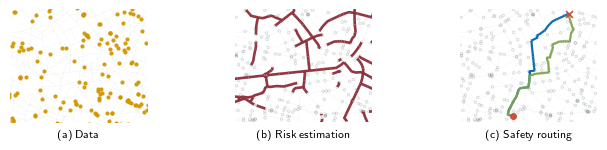

In [28]:
fig, axs = make_three_panel_figure(
    segments_df=segments_df,
    junction_df=junction_df,
    accidents_df=accidents_df,
    crossings_gdf=crossings_gdf,
    eps=0.10,
    eta=1.0,
    outpath="../report/figs/map_3_panels.pdf",
)
plt.show()